# Re-analysis of GO term drift in PMID26623667

Tong Shu Li

In this notebook we re-analyze the GO terms against their size-matched background distributions.

Instead of looking at a model in isolation, we will compare a model against randomly generated models with the same number of genes. This will give us an idea of how well this model performs against the background distribution. We saw that the average quality of the model would increase as the number of genes in the gene set increased, and therefore need to correct for this effect in order to correctly evaluate the GO terms.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from scipy.stats import percentileofscore
from tqdm import tqdm

pd.set_option("display.max_columns", 100)

In [2]:
sys.path.append("../..")

In [3]:
from src.drift import calc_drift
from src.gene_ont import parse_go_defn

In [4]:
%matplotlib inline

---

## Read the original gene expression values

In [5]:
exp = (pd
    .read_csv("../../data/PMID26623667/clean_annotated_cpm_values.tsv", sep = '\t')
    .query("cohort <= 7 & samples != 62")
    .assign(log_day = lambda df: np.log(df["day_harvested"]))
    .rename(columns = {"wormbaseid": "wormbase_id", "cohort": "sample"})
    .replace("water", "control")
)

## Read the GO annotations

In [6]:
annots = pd.read_csv("GO_annotations.tsv", sep = '\t')

In [7]:
go_defn = (parse_go_defn("../../data/gene_ontology/go.obo")
    .set_index("go_id")
)

## Read GO term modeling results (loglinear no interaction term only)

In [8]:
logres = (pd
    .read_csv("GO_term_drift_models.tsv", sep = '\t')
    .query("model == 'loglinear' & ~interaction")
    .rename(columns = {"variable": "parameter"})
)

In [9]:
logres.shape

(5349, 15)

In [10]:
logres.head()

,parameter,estimate,std_error,t_value,p_value,adj_rsq,anova_pvalue,interaction,model,go_id,num_genes,go_name,namespace,num_seq,frac_seq
7,(Intercept),0.075862,0.021930,3.459227,2.997579e-03,0.865378,0.557867,False,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432
8,log(day_harvested),0.139131,0.013991,9.944497,1.679787e-08,0.865378,0.557867,False,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432
9,drugmianserin,-0.163877,0.021676,-7.560226,7.813031e-07,0.865378,0.557867,False,loglinear,GO:0007049,569,cell cycle,biological_process,493,0.866432
21,(Intercept),0.089358,0.022706,3.935350,1.066691e-03,0.794672,0.417054,False,loglinear,GO:0031974,522,membrane-enclosed lumen,cellular_component,488,0.934866
22,log(day_harvested),0.106658,0.014486,7.362921,1.108465e-06,0.794672,0.417054,False,loglinear,GO:0031974,522,membrane-enclosed lumen,cellular_component,488,0.934866


---

## Extract out high level metadata

In [11]:
info = (logres
    [["go_id", "go_name", "num_genes", "num_seq", "adj_rsq"]]
    .drop_duplicates()
    .reset_index(drop = True)
)

In [12]:
info.shape

(1783, 5)

In [13]:
info.head()

,go_id,go_name,num_genes,num_seq,adj_rsq
0,GO:0007049,cell cycle,569,493,0.865378
1,GO:0031974,membrane-enclosed lumen,522,488,0.794672
2,GO:0008219,cell death,571,486,0.869167
3,GO:0055114,oxidation-reduction process,613,481,0.940934
4,GO:0051641,cellular localization,553,480,0.836793


---

## Process background distributions

Here we read the randomly generated background distributions and memoize the adjusted R squared values and parameter values for all the different gene set sizes.

In [14]:
def read(set_size):
    """Read models for the background distribution of a specific size
    of gene set.
    """
    floc = "../../data/PMID26623667/rand_sampling/models/size_{}.model".format(set_size)
    return (pd
        .read_csv(floc, sep = '\t')
        .query("model == 'loglinear' & ~interaction")
    )

In [15]:
def reshape(model, id_col):
    """Reshape the model information dataframe.
    
    Expects the raw output of read() as input.    
    """
    
    info = (model
        .assign(error_percent = lambda df: np.abs(df['std_error'] / df['estimate']) * 100)
        [[id_col, "parameter", "estimate", "std_error", "p_value", "error_percent"]]
        .query("parameter != '(Intercept)'")
        .replace(
            {
                "drugmianserin": "mianserin",
                "log(day_harvested)": "log_day"
            }
        )
    )
    
    return pd.melt(info, id_vars = [id_col, "parameter"])

In [16]:
def process_ref():
    """Read the model information for the background reference distributions."""
    
    num_min = 10
    num_max = 500
    step = 10

    rsq_res = []
    parameters = []
    for i in tqdm(range(num_min, num_max+step, step)):
        chunk = read(i)
        
        params = reshape(chunk, "uid")
        parameters.append(params.assign(set_size = i))

        rsq = (chunk
            [["uid", "adj_rsq"]]
            .drop_duplicates()
            .assign(set_size = i)
        )

        rsq_res.append(rsq)
        
    rsq_res = pd.concat(rsq_res).reset_index(drop = True)
    parameters = pd.concat(parameters).reset_index(drop = True)
    
    return (rsq_res, parameters)

In [17]:
ref_rsq, ref_params = process_ref()

100%|██████████| 50/50 [00:16<00:00,  2.41it/s]


In [18]:
ref_rsq.head()

,uid,adj_rsq,set_size
0,gset_size10_num0,0.853578,10
1,gset_size10_num1,0.679970,10
2,gset_size10_num10,0.258866,10
3,gset_size10_num100,0.901688,10
4,gset_size10_num1000,0.852144,10


In [19]:
ref_params.head()

,uid,parameter,variable,value,set_size
0,gset_size10_num0,mianserin,estimate,-0.769355,10
1,gset_size10_num0,log_day,estimate,0.706667,10
2,gset_size10_num1,mianserin,estimate,-1.071512,10
3,gset_size10_num1,log_day,estimate,0.848600,10
4,gset_size10_num10,mianserin,estimate,-0.148752,10


---

## Calculate adjusted R-squared percentiles

The first comparison we will do is to reference the adjusted R-squared value of the model against the background distribution. The adjusted R-squared can be thought of as a summary of how well the model fits the data.

In [20]:
def percentileof(values, score):
    """Adjusted percentile function. Modifies the maximum possible
    percentile value from 100.0% to 100% - epsilon, where epsilon is
    1/len(values).
    
    Output range: [0, 100)
    """
    res = percentileofscore(values, score)
    return res - 1/len(values) if res == 100 else res

In [21]:
def calc_nlpval(percentile, direction = 1):
    """Given a percentile value from [0, 100),
    calculates the corresponding -log(p value).
    
    Direction can be set to decide whether small or large
    percentile values correspond to small p values.
    
    direction = 1 means a percentile near 100 equates to a 
    p value near 0
    
    direction = 0 means a percentile near 0 equates to a p
    value near 0
    """
    assert direction == 0 or direction == 1
    
    pile = percentile / 100
    pile = 1 - pile if direction == 1 else pile
    
    return -np.log10(pile)

In [22]:
cache = {size: df['adj_rsq'] for size, df in ref_rsq.groupby("set_size")}

def percentile(go_id, num_seq, adj_rsq):
    # round to nearest 10
    closest = round(num_seq, -1)
    
    return percentileof(cache[closest], adj_rsq)

info["rsq_pile"] = (info
    [["go_id", "num_seq", "adj_rsq"]]
    .apply(lambda row: percentile(*row), axis = 1)
)

In [23]:
info["rsq_nlpval"] = info["rsq_pile"].map(lambda v: calc_nlpval(v))

In [24]:
info.head()

,go_id,go_name,num_genes,num_seq,adj_rsq,rsq_pile,rsq_nlpval
0,GO:0007049,cell cycle,569,493,0.865378,1.08,0.004716
1,GO:0031974,membrane-enclosed lumen,522,488,0.794672,0.00,-0.000000
2,GO:0008219,cell death,571,486,0.869167,1.50,0.006564
3,GO:0055114,oxidation-reduction process,613,481,0.940934,84.30,0.804100
4,GO:0051641,cellular localization,553,480,0.836793,0.18,0.000782


## Examine R squared percentile distribution

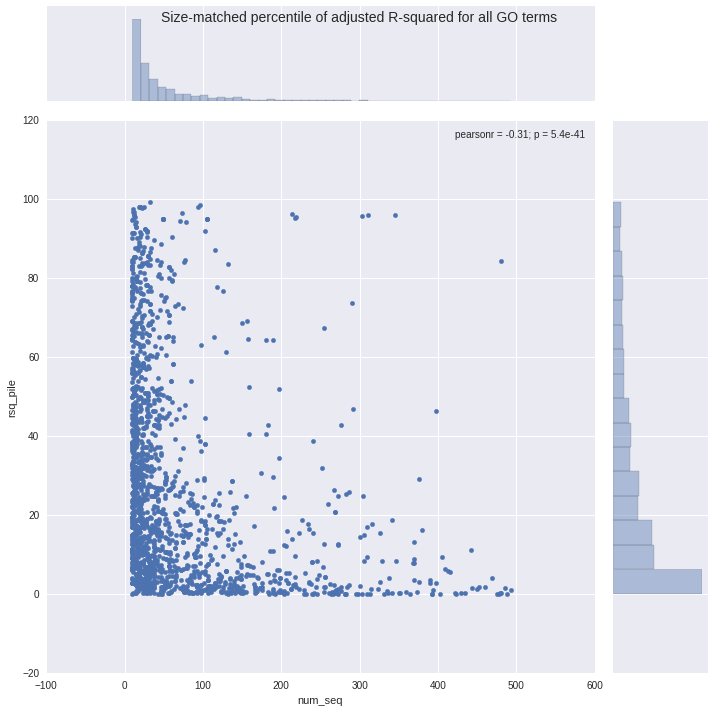

In [25]:
g = sns.jointplot(
    data = info,
    x = "num_seq", y = "rsq_pile",
    kind = "scatter", size = 10
)

g.fig.suptitle("Size-matched percentile of adjusted R-squared for all GO terms", fontsize = 14);

We see that most of the larger GO terms have low adjusted R-squared percentile values. This means that the GO provides no additional benefit for constructing gene sets than selecting genes randomly. However, in the smaller gene sets, there is much more variability.

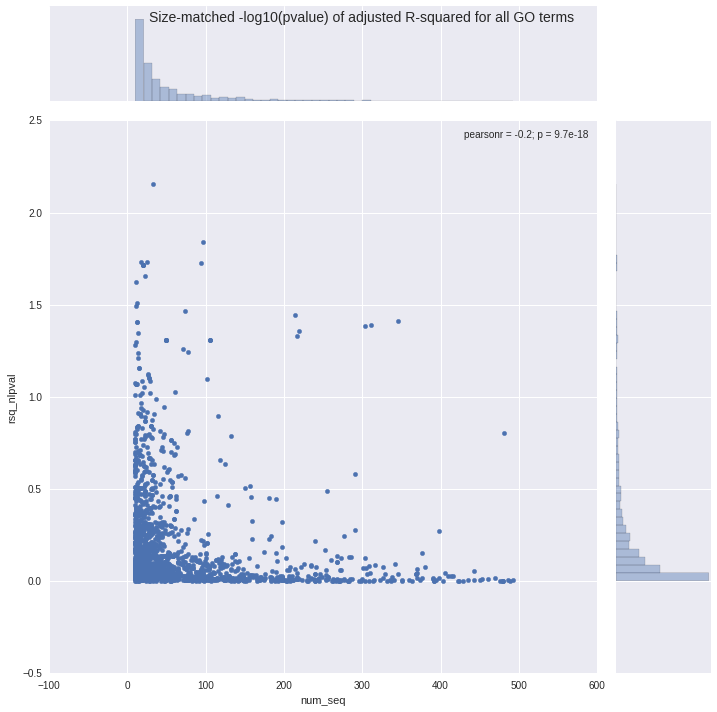

In [26]:
g = sns.jointplot(
    data = info,
    x = "num_seq", y = "rsq_nlpval",
    kind = "scatter", size = 10
)

g.fig.suptitle("Size-matched -log10(pvalue) of adjusted R-squared for all GO terms", fontsize = 14);

When we plot the negative log p-value instead of the percentile, we stratify the top results more.

In [27]:
info.sort_values("rsq_nlpval", ascending = False).head(10)

,go_id,go_name,num_genes,num_seq,adj_rsq,rsq_pile,rsq_nlpval
870,GO:0042493,response to drug,75,33,0.950727,99.30,2.154902
386,GO:0009617,response to bacterium,111,96,0.956516,98.56,1.841638
1037,GO:0006323,DNA packaging,28,25,0.931179,98.14,1.730487
1271,GO:0034728,nucleosome organization,21,18,0.931281,98.14,1.730487
394,GO:0042742,defense response to bacterium,109,94,0.952737,98.12,1.725842
1193,GO:0017144,drug metabolic process,39,20,0.930678,98.07,1.714443
1208,GO:0071466,cellular response to xenobiotic stimulus,39,20,0.930678,98.07,1.714443
1206,GO:0042738,exogenous drug catabolic process,39,20,0.930678,98.07,1.714443
1205,GO:0042737,drug catabolic process,39,20,0.930678,98.07,1.714443
1187,GO:0006805,xenobiotic metabolic process,39,20,0.930678,98.07,1.714443


As expected, the larger gene sets have R-squared values which we would roughly expect for any random gene set of that size, and the fact that the genes are grouped together by GO term does not provide any additional information, or make the GO term better. There are however a few large GO terms which do have high R-squared values.

At the small GO term size, we see that the distribution is more uniform, but still weighted towards lower R-squared percentiles. For some of the gene sets, the GO term provides information that helps fit a better linear model to the data. Before we can conclude that these GO terms are better, we will need to also examine the parameters of the model.

---

## Model parameter scoring

We want some more information about the models other than just the adjusted R squared value. Hence we will compare the variable beta estimates to the reference distributions, and ensure that the errors on the estimates are taken into account.

In [28]:
go_params = (reshape(logres, "go_id")
    .merge(info[["go_id", "num_seq"]], how = "left", on = "go_id")
)

cache = dict()
for (size, param, var), df in ref_params.groupby(["set_size", "parameter", "variable"]):
    cache[(size, param, var)] = df["value"]

def calc_percentile(num_seq, parameter, variable, value):
    # round to nearest 10
    closest = round(num_seq, -1)
    
    ref_vals = cache[(closest, parameter, variable)]
    return percentileof(ref_vals, value)

go_params["percentile"] = (go_params
    [["num_seq", "parameter", "variable", "value"]]
    .apply(lambda row: calc_percentile(*row), axis = 1)
)

In [29]:
go_params.head()

,go_id,parameter,variable,value,num_seq,percentile
0,GO:0007049,log_day,estimate,0.139131,493,0.00
1,GO:0007049,mianserin,estimate,-0.163877,493,99.75
2,GO:0031974,log_day,estimate,0.106658,488,0.00
3,GO:0031974,mianserin,estimate,-0.145002,488,99.92
4,GO:0008219,log_day,estimate,0.161059,486,0.00


---

## Calculate a final score

The final score for a gene set is simply the sum of the negative log pvalues of the adjusted r-squared, the day estimate, and the drug estimate. Trying to include other model parameters offered no additional benefit.

In [30]:
def rearrange(df):
    res = dict()
    
    name = {
        "estimate": "est",
        "std_error": "error",
        "p_value": "pval",
        "error_percent": "error_percent"
    }
    
    for (param, variable), sub in df.groupby(["parameter", "variable"]):
        temp = sub.iloc[0]
        
        res["{}_{}".format(param, name[variable])] = temp['value']
        
        if variable == 'estimate':
            res["{}_{}_pile".format(param, name[variable])] = temp['percentile']
        
    return pd.Series(res)

In [31]:
final = (info
    .assign(frac_seq = lambda df: df["num_seq"] / df["num_genes"])
    .merge(
        go_params.groupby("go_id").apply(rearrange).reset_index(),
        how = "left", on = "go_id"
    )
)

In [32]:
def score(**row):
    # use log(1 - value) when larger values are better
    # use log(value) when smaller values are better
    
    return (row["rsq_nlpval"]
        + calc_nlpval(row["log_day_est_pile"])
        + calc_nlpval(row["mianserin_est_pile"], direction = 0)
    )

final["score"] = final.apply(lambda r: score(**r), axis = 1)

## Examine results

In [33]:
final.shape

(1783, 19)

In [34]:
final.head()

,go_id,go_name,num_genes,num_seq,adj_rsq,rsq_pile,rsq_nlpval,frac_seq,log_day_error,log_day_error_percent,log_day_est,log_day_est_pile,log_day_pval,mianserin_error,mianserin_error_percent,mianserin_est,mianserin_est_pile,mianserin_pval,score
0,GO:0007049,cell cycle,569,493,0.865378,1.08,0.004716,0.866432,0.013991,10.055813,0.139131,0.00,1.679787e-08,0.021676,13.227119,-0.163877,99.7500,7.813031e-07,0.005803
1,GO:0031974,membrane-enclosed lumen,522,488,0.794672,0.00,-0.000000,0.934866,0.014486,13.581567,0.106658,0.00,1.108465e-06,0.022443,15.477964,-0.145002,99.9200,5.866465e-06,0.000348
2,GO:0008219,cell death,571,486,0.869167,1.50,0.006564,0.851138,0.015796,9.807859,0.161059,0.00,1.164180e-08,0.024474,13.271532,-0.184409,99.3800,8.169055e-07,0.009265
3,GO:0055114,oxidation-reduction process,613,481,0.940934,84.30,0.804100,0.784666,0.017312,6.973754,0.248249,0.02,6.312763e-11,0.026822,17.743879,0.151164,99.9999,2.965003e-05,0.804188
4,GO:0051641,cellular localization,553,480,0.836793,0.18,0.000782,0.867993,0.024470,11.350614,0.215581,0.00,9.582997e-08,0.037912,14.477480,-0.261866,92.0300,2.536375e-06,0.036853


## Plots

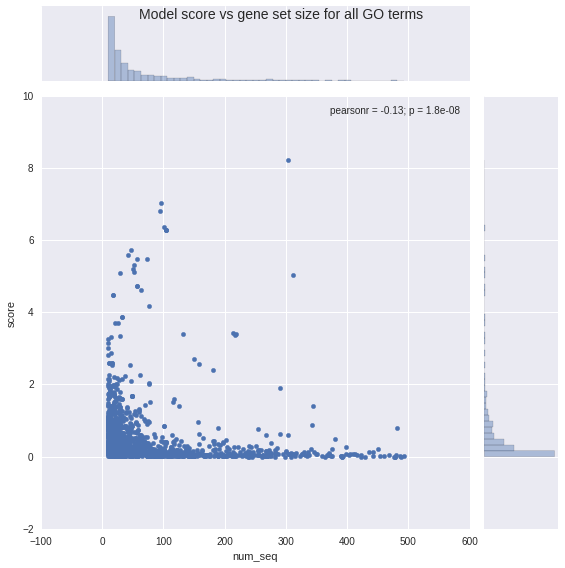

In [35]:
g = sns.jointplot(
    data = final,
    x = "num_seq", y = "score",
    size = 8
)

g.fig.suptitle("Model score vs gene set size for all GO terms", fontsize = 14);

It's interesting that the highest scoring model has around 300 genes. The distribution of score to gene set size looks slightly different from the plot of adjusted R squared percentiles above.

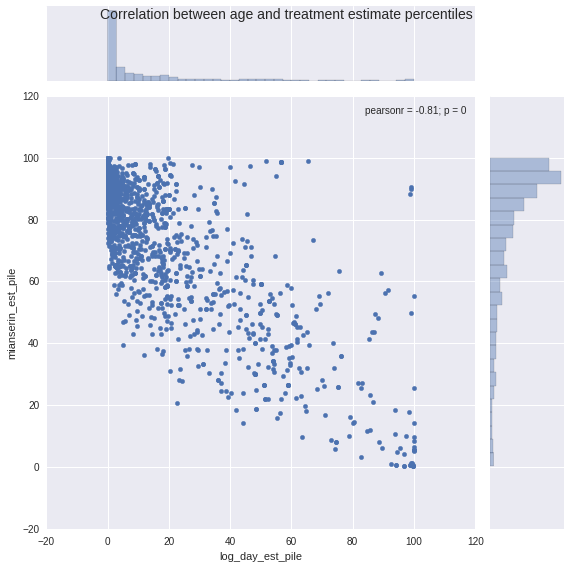

In [36]:
g = sns.jointplot(
    data = final,
    x = "log_day_est_pile",
    y = "mianserin_est_pile",
    size = 8
)

g.fig.suptitle("Correlation between age and treatment estimate percentiles", fontsize = 14);

There also is some correlation between the day estimate's percentile with the mianserin estimate percentile. This perhaps can be explained by the fact that when there is more drift with time, then the drug can have a larger absolute effect, and therefore may not be necessarily surprising.

## Top 50 results (no filter)

In [37]:
final.sort_values("score", ascending = False).head(50)

,go_id,go_name,num_genes,num_seq,adj_rsq,rsq_pile,rsq_nlpval,frac_seq,log_day_error,log_day_error_percent,log_day_est,log_day_est_pile,log_day_pval,mianserin_error,mianserin_error_percent,mianserin_est,mianserin_est_pile,mianserin_pval,score
65,GO:0006952,defense response,425,303,0.951926,95.85,1.381952,0.712941,0.044340,5.143358,0.862077,99.9999,4.747700e-13,0.068697,17.318591,-0.396664,14.12,2.245323e-05,8.232117
386,GO:0009617,response to bacterium,111,96,0.956516,98.56,1.841638,0.864865,0.038477,4.923978,0.781415,99.9900,2.329447e-13,0.059613,12.186028,-0.489191,6.44,2.577013e-07,7.032752
394,GO:0042742,defense response to bacterium,109,94,0.952737,98.12,1.725842,0.862385,0.040619,5.133895,0.791196,99.9900,4.607240e-13,0.062932,13.123537,-0.479538,8.33,7.035949e-07,6.805197
366,GO:0098542,defense response to other organism,121,102,0.938816,91.99,1.096367,0.842975,0.046742,5.892114,0.793297,99.9900,4.297227e-12,0.072419,14.469245,-0.500500,5.49,2.518022e-06,6.356795
349,GO:0051707,response to other organism,124,105,0.945016,95.06,1.306273,0.846774,0.043266,5.577361,0.775740,99.9800,1.770918e-12,0.067033,13.369790,-0.501376,5.38,9.008626e-07,6.274461
348,GO:0043207,response to external biotic stimulus,124,105,0.945016,95.06,1.306273,0.846774,0.043266,5.577361,0.775740,99.9800,1.770918e-12,0.067033,13.369790,-0.501376,5.38,9.008626e-07,6.274461
347,GO:0009607,response to biotic stimulus,124,105,0.945016,95.06,1.306273,0.846774,0.043266,5.577361,0.775740,99.9800,1.770918e-12,0.067033,13.369790,-0.501376,5.38,9.008626e-07,6.274461
674,GO:0030968,endoplasmic reticulum unfolded protein response,70,47,0.892530,75.86,0.617263,0.671429,0.073686,8.290772,0.888771,99.7600,9.303790e-10,0.114164,14.393289,-0.793172,0.32,2.354194e-06,5.731902
720,GO:0009408,response to heat,69,43,0.891900,80.54,0.710857,0.623188,0.077150,8.350585,0.923888,99.6700,1.038570e-09,0.119531,14.175157,-0.843239,0.41,1.934851e-06,5.579559
496,GO:0050829,defense response to Gram-negative bacterium,82,73,0.945906,96.57,1.464706,0.890244,0.045018,5.507485,0.817402,99.9000,1.443755e-12,0.069748,14.213962,-0.490700,9.75,2.004217e-06,5.475701


Notice that some of the results are redundant, since some GO terms share more than 90% of their genes.

## Top scoring results (with filters)

The following results would be what I consider to be the best results. While the aggregate score is our best attempt at summarizing multiple parameters, it is not immediately human interpretable. The constraints specificed below are much easier to understand and explain when detailing which gene sets were selected for additional sequencing.

In [38]:
spec = (
    "num_seq < 120"
    " & rsq_pile > 80"
    " & log_day_est > 0"
    " & mianserin_est < 0"
    " & log_day_error_percent < 20"
    " & mianserin_error_percent < 20"
)

res = final.query(spec).sort_values("score", ascending = False)
print(len(res))

res

94


,go_id,go_name,num_genes,num_seq,adj_rsq,rsq_pile,rsq_nlpval,frac_seq,log_day_error,log_day_error_percent,log_day_est,log_day_est_pile,log_day_pval,mianserin_error,mianserin_error_percent,mianserin_est,mianserin_est_pile,mianserin_pval,score
386,GO:0009617,response to bacterium,111,96,0.956516,98.56,1.841638,0.864865,0.038477,4.923978,0.781415,99.99,2.329447e-13,0.059613,12.186028,-0.489191,6.44,2.577013e-07,7.032752
394,GO:0042742,defense response to bacterium,109,94,0.952737,98.12,1.725842,0.862385,0.040619,5.133895,0.791196,99.99,4.607240e-13,0.062932,13.123537,-0.479538,8.33,7.035949e-07,6.805197
366,GO:0098542,defense response to other organism,121,102,0.938816,91.99,1.096367,0.842975,0.046742,5.892114,0.793297,99.99,4.297227e-12,0.072419,14.469245,-0.500500,5.49,2.518022e-06,6.356795
347,GO:0009607,response to biotic stimulus,124,105,0.945016,95.06,1.306273,0.846774,0.043266,5.577361,0.775740,99.98,1.770918e-12,0.067033,13.369790,-0.501376,5.38,9.008626e-07,6.274461
348,GO:0043207,response to external biotic stimulus,124,105,0.945016,95.06,1.306273,0.846774,0.043266,5.577361,0.775740,99.98,1.770918e-12,0.067033,13.369790,-0.501376,5.38,9.008626e-07,6.274461
349,GO:0051707,response to other organism,124,105,0.945016,95.06,1.306273,0.846774,0.043266,5.577361,0.775740,99.98,1.770918e-12,0.067033,13.369790,-0.501376,5.38,9.008626e-07,6.274461
720,GO:0009408,response to heat,69,43,0.891900,80.54,0.710857,0.623188,0.077150,8.350585,0.923888,99.67,1.038570e-09,0.119531,14.175157,-0.843239,0.41,1.934851e-06,5.579559
496,GO:0050829,defense response to Gram-negative bacterium,82,73,0.945906,96.57,1.464706,0.890244,0.045018,5.507485,0.817402,99.90,1.443755e-12,0.069748,14.213962,-0.490700,9.75,2.004217e-06,5.475701
1029,GO:0051260,protein homooligomerization,56,26,0.884979,83.92,0.793714,0.464286,0.060959,8.679959,0.702301,96.91,1.872155e-09,0.094446,14.404470,-0.655671,4.11,2.377703e-06,3.689914
933,GO:0051259,protein oligomerization,60,30,0.883709,83.42,0.780415,0.500000,0.056027,8.765085,0.639206,95.45,2.170567e-09,0.086804,14.278637,-0.607929,6.19,2.124729e-06,3.330713


---

## Save plots for the top 200 results

Could not figure out how to release memory after creating a plot, so I can't generate all of the GO term's plots. The estimates of the 95% confidence interval will change each time (since it is bootstrapped), but the values of the points remain constant.

In [39]:
def examine(go_id, score = None, num_seq = None):
    sub = (annots
        .query("go_id == @go_id")
        .merge(exp, how = "left", on = "wormbase_id")
    )
    
    drift = calc_drift(sub, ["sample", "replicate", "drug", "day_harvested", "log_day"], "RLFEC")
    
    g = sns.lmplot(
        data = drift,
        x = "log_day", y = "drift",
        hue = "drug", size = 9,
        markers = ['o', 'x']
    )
    
    go_name = go_defn.loc[go_id, "go_name"]
    g.fig.suptitle(
        "Drift for '{}' ({})\n"
        "Genes: {} Score: {:.4f}".format(go_name, go_id, num_seq, score), fontsize = 14
    )
    
    return g

In [40]:
# top 500 results by score
best = final.sort_values("score", ascending = False)[:200]

for idx, row in tqdm(best.iterrows(), total = len(best)):
    go_id = row["go_id"]
    score = row["score"]
    num_seq = row["num_seq"]
    
    plot = examine(go_id, score, num_seq)
    
    fname = "../../results/PMID26623667/GO_plots/{}.png".format(go_id)
    plot.savefig(fname, dpi = 200)
    plt.close('all')

100%|██████████| 200/200 [03:59<00:00,  1.30s/it]


## Save results

In [41]:
final.sort_values("go_id").to_csv("../../results/PMID26623667/GO_drift_results.tsv", sep = '\t', index = False)

In [42]:
res.to_csv("../../results/PMID26623667/best_GO_drift_results.tsv", sep = '\t', index = False)